Importieren der benötigten packages

In [1]:
import json
import requests
#import collections
from collections import Counter
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

Laden der bereits gereinigten Daten aus einer JSON-Datei

In [2]:
with open('../../data/speeches_preprocessed.json', 'r') as fp:
    data = json.load(fp)

In [3]:
alleReden = data.copy()

In [4]:
for rede in alleReden:
    if rede['name']=='Albert H. Weiler':
        rede['name']='Albert Weiler'
    if rede['name']=='Eva-Maria Elisabeth Schreiber':
        rede['name']='Eva-Maria Schreiber'
    if rede['name']=='Heidrun Bluhm-Förster':
        rede['name']='Heidrun Bluhm'
    if rede['name']==' in der Beek':
        rede['name']='Olaf in der Beek'
    if rede['name']==' ':
        rede['name']='Unbekannt'
    if rede['name']=='Eberhardt Alexander Gauland':
        rede['name']='Alexander Gauland'
    if rede['name']=='Joana Eleonora Cotar':
        rede['name']='Joana Cotar'
    if rede['name']=='Wolfgang Schäuble':
        rede['name']='Dr. Wolfgang Schäuble'
    if rede['name']=='Thomas de Maizière':
        rede['name']='Thomas Maizière'
    if rede['name']=='Alterspräsident Dr. Hermann Otto Solms':
        rede['name']='Hermann Otto Solms'
    if rede['name']=='Konstantin Elias Kuhle':
        rede['name']='Konstantin Kuhle'
    if rede['name']=='Konstantin Elias Kuhle':
        rede['name']='Konstantin Kuhle'
    if rede['name']=='Elvan Korkmaz':
        rede['name']='Elvan Korkmaz-Emre'

Es werden nur Nomen berücksichtigt

In [5]:
consider = ['NOUN']
for rede in tqdm(alleReden):
    rel_lemmata = [ ele for ex,ele in enumerate(rede['text_lem']) if rede['text_pos'][ex] in consider ]
    rede['text_lem'] = rel_lemmata
    rede['text_pos'] = [ele for ele in rede['text_pos'] if ele in consider]

100%|██████████| 24666/24666 [00:03<00:00, 7477.46it/s]


In [6]:
reden_clean = alleReden

Erstellt eine Liste aller Parlamentarier, sowie ihrer dazugehörigen Parteien

In [7]:

def get_names_and_parties(reden_clean):
    names = []
    parties = []
    for rede in reden_clean:
        if rede['name'] not in names:
            names.append(rede['name'])
            parties.append(rede['party'])
    return names, parties

In [11]:
names, parties = get_names_and_parties(reden_clean)

Erzeugt eine liste von dicts, welche jeweils einen der Parlamentarier enthalten. In den jeweiligen dicts sind außerdem ein Index, und die Parteizugehörigkeit des jeweiligen Parlamentariers gespeichert.

In [8]:
def get_text_clean(name, reden):
    text = ''
    nReden = 0
    nWorte = 0
    for rede in reden:
        if rede['name'] == name:
            nReden += 1
            nWorte += len(rede['text_lem'])
            text += ' '.join(rede['text_lem'])
    return text, nReden, nWorte
   

In [9]:
def liste_von_parla_mit_dict_text(reden, names, parties):
    
    parlamentarier = []

    for count,name in enumerate(names):
        hilf = {
            'id':count+1,
            'name': names[count],
            'party': parties[count]
        }
        
        text, nReden, nWorte = get_text_clean(name, reden) 
            
        hilf.update({'text_lem': text, 'nReden': nReden, 'nWorte': nWorte})
        
        parlamentarier.append(hilf)
    
    return parlamentarier

In [12]:
parlamentarier = liste_von_parla_mit_dict_text(reden_clean, names, parties)

Erstellt eine Matrix, welche als Zeilen die einzelnen Parlamentarier enthält. Die Zeilen sind gegeben durch die von allen Rednern gesagten Worte. 
Die einzelnen Eniträge sind die tf-idf Gewichte des von einem Parlamentarier gesagten Wortes.
Die Berechnung der tfidf erfolgt folgerndermaßen:

tf-idf(t, d) = tf(t, d) * idf(t)

tf(t,d) = termfrequency des Terms t im Dokument d

idf(t,d) = log [ (1 + n) / (1 + df(t)) ] + 1 inverse 

wobei df(t) die document frequency eines Wortes ist, also in wie vielen Worten eine Dokument vorkommt.

In [13]:
corpus = [ parla['text_lem'] for parla in parlamentarier ]
vectorizer = TfidfVectorizer(max_df=0.8, min_df=(2/781))
tf_idf_matrix  = vectorizer.fit_transform(corpus)

erstelllt eine liste von dicts, wobei jedes dict folgende Info enthält:
        - index
        
        - name des parlamentariers
        
        - Partei des Parlamentareirs
        
        - Anzahl der gehaltenen Reden
        
        - lemmatisiter Text aus allen Reden deíe der Parlamentarier gehalten hat
        
        - vec_number vektor der tfidf gewichte aus der tfidf matrix
        
        - msw ist das wort, welches das höchste gewicht im tfidf vetkro erhalten hat
        

In [14]:
def liste_von_parla_mit_dict_vec(reden, parlamentarier, X_csr, vectorizer):
    
    parlamentarier_vec = []

    for count, parla in enumerate(parlamentarier):
        hilf = {
            'id':count+1,
            'name': parla['name'],
            'party': parla['party'],
            'nReden': parla['nReden'],
            'nWorte':parla['nWorte'],
            'text': parla['text_lem']
        }
        
        vec_numbers = np.array(X_csr.getrow(count).toarray()[0])
        
        maxWX = np.argmax(vec_numbers)
          
        #vec_numbers = vec_numbers/np.linalg.norm(vec_numbers)
        
        hilf.update({'vec_numbers': vec_numbers})
        msw = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(np.argmax(vec_numbers))]
        hilf.update({'maxTFIDF': msw})
        
        
        parlamentarier_vec.append(hilf)
    
    return parlamentarier_vec

In [15]:
parlamentarier_vec = liste_von_parla_mit_dict_vec(reden_clean, parlamentarier, tf_idf_matrix.copy(), vectorizer)

Berechnet die Cosinusähnlichkeit zweier Parlamentarier anhand des Skalarproduktes zweier Parlamentarier

In [16]:
pairwise_similarity = tf_idf_matrix * tf_idf_matrix.T 

similarity = pairwise_similarity.toarray()

Erstellt den Graphen. Die Knoten sind die Parlamentarier und das Gewicht ist die semantische Ähnlichkeit zweier Parlamentarier

In [17]:
def cos_sim(vec_a, vec_b):
    
    return np.dot(vec_a, vec_b) /(np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

In [18]:
def cotop_graph_erstellen(parlamentarier, min_weight, similarity):

    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': parlamentarier,
    }

    for ix,nodeI in enumerate(graph['nodes']):
        for jx,nodeJ in enumerate(graph['nodes']):
            if nodeI['id'] < nodeJ['id']:
                source = nodeI['id']
                target = nodeJ['id']
                #weight = cos_sim(nodeI['vec_numbers'], nodeJ['vec_numbers'])
                #r = np.corrcoef(nodeI['vec_numbers'], nodeJ['vec_numbers'])
                #weight = r[0,1]
                weight = similarity[ix,jx]
                if weight > min_weight:
                    link_dict = {
                        'source':source,
                        'target':target,
                        'weight':weight       
                    }
                    graph['links'].append(link_dict)
    return graph

In [19]:
graph = cotop_graph_erstellen(parlamentarier_vec, 0.25, similarity)

This graph has 770 nodes and 7842 links.


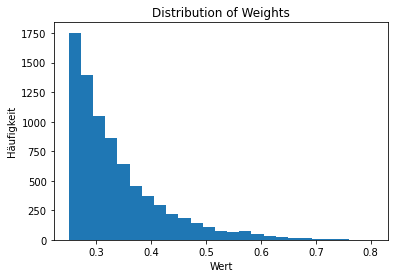

In [20]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

import matplotlib.pyplot as plt

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

Überführt den Graphen in einen Graphen, der mithilfe von Gephi verarbeitet werden kann.

In [21]:
import networkx as nx

graphforgephi = nx.Graph()
for node in graph['nodes']:
    graphforgephi.add_node(node['id'],name=node['name'],party=node['party'],msw=node['maxTFIDF'],nReden=node['nReden'],nWorte=node['nWorte']);

for link in graph['links']:
    if link['weight'] >= 0.25:
        graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'], community=0)

Berechnet die vorhandenen Nachbarschaften im Graohen anhand des Louivain-Algorithmusses und fügt sie den Knoten hinzu.

In [22]:
import community as community_louvain
# compute the best partition
partition = community_louvain.best_partition(graphforgephi)

AttributeError: module 'community' has no attribute 'best_partition'

In [23]:
#Update der Knoten mit der dazugehörigen community
for i,node in enumerate(graphforgephi):
    graphforgephi.add_node(node, partition_val=list(partition.values())[i])

In [26]:
#speichern des Graphen, damit er in Gephi genutzt werden kann
nx.write_gexf(graphforgephi, "graphforgephi_08_v2.gexf")

### Write Graph Data for JS/HTML 


In [27]:
graph['nodes'][10]

{'id': 11,
 'name': 'Thomas Oppermann',
 'party': 'SPD',
 'nReden': 6,
 'nWorte': 643,
 'text': 'Herr Präsident Wahl Zusammenarbeit Herr Kollege WahlHerr Präsident Dame Herr Fußballweltmeisterschaft Timing Antragsteller Million Mensch Welt Fußballspiele Freude Rede Herr Woche Abend Fernseher Mannschaft Konsens Debatte Fußball Sport Sport Waffe Weg Ordnung Anlass Fußballweltmeisterschaft Situation Gastgeberland Russland Debatte Bundeskanzlerin Treffen Präsident Putin Interesse Beziehung Russland Russland Nachbar Union Land Welt Deutsche Hinsicht Land Million Mensch Weltkrieg Jahrzehnt Besatzungsmacht Weg Einheit Gewalt Blutvergießen Grund Russe Beziehung Jahr Differenz Russland Annexion Krim Völkerrecht Eskalation Ostukraine Bewertung Cyberangriffen Institution Finanzierung Partei Rolle Bürgerkrieg Verständnis Demokratie Menschenrechten Russland Pressefreiheit Pressefreiheit Seppelt Angst Reporter Russland Russland Land Atomwaffen Verhältnis Belehrungen Antrag Idee Weltmeisterschaft Ges

In [28]:

for node in graph['nodes']:
    node.pop('vec_numbers', None)


with open('networkdata.json', 'w') as fp:
    json.dump(graph, fp)